In [1]:
!pip install casadi
from IPython.display import clear_output
import os

import numpy as np
import casadi
import time
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation

os.makedirs('images',exist_ok=True)
if os.name == 'nt':
    plt.rcParams['font.family'] = 'MS Gothic'
elif os.name == 'posix':
    !pip install japanize-matplotlib

clear_output()

In [2]:
g = 9.81 #重力加速度
M = 1 #台車の質量
m = 0.2 #振子の質量
l = 1 #振子の長さ

nu = 1 #制御変数の次元
nx = 4 #状態変数の次元

# コスト関数の重み
Q = casadi.diag([2.5,10,0.01,0.01])
Q_f = casadi.diag([2.5,10,0.01,0.01])
R = casadi.diag([0.1])

# 予測ホライズン等
T = 1
K = 20
dt = T/K

# 制約条件
x_lb = [-np.inf,-np.inf,-np.inf,-np.inf]
x_ub = [np.inf,np.inf,np.inf,np.inf]
u_lb = [-15]
u_ub = [15]

total = nx*(K+1) + nu*K

In [3]:
def make_f():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    x = states[0]
    theta = states[1]
    x_dot = states[2]
    theta_dot = states[3]
    F = ctrls[0]

    sin = casadi.sin(theta)
    cos = casadi.cos(theta)
    det = M+m*sin**2

    x_ddot = (-m*l*sin*theta_dot**2+m*g*sin*cos+F)/det
    theta_ddot = (-m*l*sin*cos*theta_dot**2+(M+m)*g*sin+F*cos)/(l*det)

    states_dot = casadi.vertcat(x_dot,theta_dot,x_ddot,theta_ddot)

    f = casadi.Function("f",[states,ctrls],[states_dot],['x','u'],['x_dot'])
    return f

def make_RK4():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()

    r1 = f(x=states,u=ctrls)["x_dot"]
    r2 = f(x=states+dt*r1/2,u=ctrls)["x_dot"]
    r3 = f(x=states+dt*r2/2,u=ctrls)["x_dot"]
    r4 = f(x=states+dt*r3,u=ctrls)["x_dot"]

    states_next = states + dt*(r1+2*r2+2*r3+r4)/6

    RK4 = casadi.Function("RK4",[states,ctrls],[states_next],["x","u"],["x_next"])
    return RK4

def make_integrator():
    states = casadi.SX.sym("states",nx)
    ctrls = casadi.SX.sym("ctrls",nu)

    f = make_f()
    ode = f(x=states, u=ctrls)["x_dot"]

    dae = {"x":states,"p":ctrls,"ode":ode}

    I = casadi.integrator("I","cvodes",dae,0,dt)
    return I

def compute_stage_cost(x,u):
    cost = (casadi.dot(Q@x,x) + casadi.dot(R@u,u)) / 2
    return cost

def compute_terminal_cost(x):
    cost = casadi.dot(Q_f@x,x) / 2
    return cost

In [4]:
nm = 2
c = casadi.collocation_points(nm, 'legendre')
D_T, beta_, b = casadi.collocation_coeff(c)
D = D_T.T[:,1:]
beta = beta_[1:]
print("b",b)
print("c",c)
print("D",D)
print("beta",beta)

b [0.5, 0.5]
c [0.21132486540518713, 0.7886751345948129]
D 
[[3, 0.464102], 
 [-6.4641, 3]]
beta [-1.73205, 1.73205]


In [5]:
# nm = 2
# c = casadi.collocation_points(nm, 'legendre')

# A = np.zeros((nm,nm))
# b = np.zeros(nm)
# for j in range(nm):
#     lj = 1
#     for l in range(nm):
#         if l != j:
#             lj *= np.poly1d([1, -c[l]]) / (c[j]-c[l])
#     lj_int = np.polyint(lj)
#     b[j] = lj_int(1)-lj_int(0)
#     for i in range(nm):
#         A[i,j] = lj_int(c[i])-lj_int(0)
# D = np.linalg.inv(A)
# beta = D.T@b
# print("A",A)
# print("b",b)
# print("c",c)
# print("D",D)
# print("beta",beta)

In [6]:
def make_nlp_dc():
    f = make_f()

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(K)]
    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(K+1)]
    Xc = []
    for k in range(K):
        for j in range(nm):
            Xc.append( casadi.SX.sym(f"x_{k}_{j}",nx) )
        
    G = []
    J = 0
    for k in range(K):
        Xk_end = 1*X[k]
        for j in range(nm):
            xp = 0
            for r in range(nm):
                xp = xp + D[j,r]*(Xc[k*nm+r]-X[k])

            fj = f(Xc[k*nm+j],U[k])
            Xk_end = Xk_end + beta[j]*Xc[k*nm+j]
            J = J + b[j]*compute_stage_cost(Xc[k*nm+j],U[k])*dt
            G.append(dt*fj - xp)
        G.append(Xk_end-X[k+1])
    J += compute_terminal_cost(X[-1])
    
    option = {'print_time':False,'ipopt':{'print_level':0}}
    nlp = {"x":casadi.vertcat(*X,*Xc,*U),"f":J,"g":casadi.vertcat(*G)}
    S = casadi.nlpsol("S","ipopt",nlp,option)
    return S

In [7]:
def compute_optimal_control_dc(S_dc,x_init,x0_dc):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + x_lb*K*(1+nm) + u_lb*K
    ubx = x_init + x_ub*K*(1+nm) + u_ub*K
    lbg = [0]*nx*K*(1+nm)
    ubg = [0]*nx*K*(1+nm)

    res = S_dc(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0_dc)
    
    offset = nx + nx*K*(1+nm)
    x0_dc = res["x"]
    u_opt = x0_dc[offset:offset+nu]
    return u_opt, x0_dc

In [8]:
S_dc = make_nlp_dc()

In [9]:
def make_nlp():
    RK4 = make_RK4()

    U = [casadi.SX.sym(f"u_{i}",nu) for i in range(K)]
    X = [casadi.SX.sym(f"x_{i}",nx) for i in range(K+1)]
    G = []

    J = 0

    for k in range(K):
        J += compute_stage_cost(X[k],U[k]) * dt
        eq = X[k+1] - RK4(x=X[k],u=U[k])["x_next"]
        G.append(eq)
    J += compute_terminal_cost(X[-1])

    option = {'print_time':False,'ipopt':{'print_level':0}}
    nlp = {"x":casadi.vertcat(*X,*U), "f":J,"g":casadi.vertcat(*G)}
    S = casadi.nlpsol("S","ipopt",nlp,option)
    return S

In [10]:
def compute_optimal_control(S,x_init,x0):
    x_init = x_init.full().ravel().tolist()
    
    lbx = x_init + x_lb*K + u_lb*K
    ubx = x_init + x_ub*K + u_ub*K
    lbg = [0]*nx*K
    ubg = [0]*nx*K

    res = S(lbx=lbx,ubx=ubx,lbg=lbg,ubg=ubg,x0=x0)

    offset = nx*(K+1)
    x0 = res["x"]
    u_opt = x0[offset:offset+nu]
    return u_opt, x0

In [11]:
S = make_nlp()

In [12]:
x_init = casadi.DM([0,np.pi,0,0])

x0_dc = casadi.DM.zeros(nx + nx*K*(1+nm) + nu*K)
start_time = time.perf_counter()
u_opt, x0_dc = compute_optimal_control_dc(S_dc,x_init,x0_dc)
dc_time = time.perf_counter() - start_time

x0 = casadi.DM.zeros(total)
start_time = time.perf_counter()
u_opt, x0 = compute_optimal_control(S,x_init,x0)
dms_time = time.perf_counter() - start_time


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



In [13]:
print("dc_time",dc_time)
print("dms_time",dms_time)

dc_time 0.0389309898018837
dms_time 0.02352881385013461


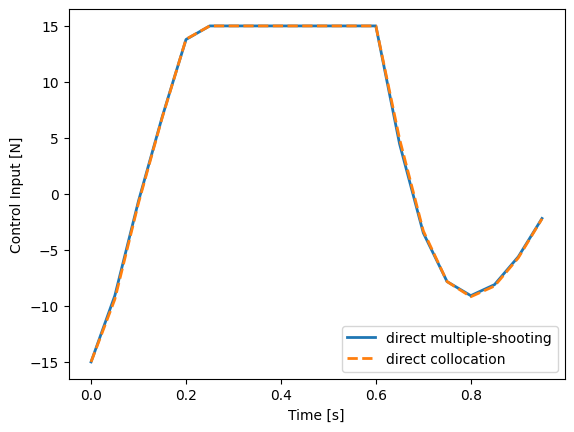

In [14]:
timestamp = np.array(range(K))* dt
plt.plot(timestamp, x0[nx*(K+1):],linewidth=2,label="direct multiple-shooting")
plt.plot(timestamp, x0_dc[nx + nx*K*(1+nm):],"--",linewidth=2,label="direct collocation")
plt.xlabel("Time [s]")
plt.ylabel("Control Input [N]")
plt.legend()
plt.savefig("images/chap6_collocation_control_trajectory.png")